In [2]:
import pandas as pd
import numpy as np
import pickle

In [3]:
#read the first 10000 rows of data/workid_authorid_institutionid_pubdate24.csv
paper_data = pd.read_csv('data/workid_authorid_institutionid_pubdate24.csv', nrows=100000, index_col=0)
# read data/institution_geo24.pkl
with open('data/institution_geo24.pkl', 'rb') as f:
    institution_geo = pickle.load(f)
institution_geo

,institution_id,city,region,country_code,country,latitude,longitude
0,I220871436,NaN,NaN,FR,NaN,48.848610,2.342780
1,I4210140407,Portland,Oregon,US,United States,45.525047,-122.672940
2,I4210121796,London,NaN,GB,United Kingdom,51.544495,-0.056045
3,I2800206933,Vienna,NaN,AT,Austria,48.204475,16.357422
4,I2802204158,Salem,Oregon,US,United States,44.886715,-123.031906
...,...,...,...,...,...,...,...
108136,I4394709273,Washington,NaN,NaN,United States,38.895110,-77.036370
108137,I4394709274,Delft,NaN,NaN,The Netherlands,52.006670,4.355560
108138,I4394709279,Washington,NaN,NaN,United States,38.895110,-77.036370
108139,I82930923,London,NaN,GB,United Kingdom,51.531994,-0.119311


In [4]:
# drop institutions with invalid geo information
institution_geo.dropna(subset=['city', 'country_code'], inplace=True)
institution_geo

,institution_id,city,region,country_code,country,latitude,longitude
1,I4210140407,Portland,Oregon,US,United States,45.525047,-122.672940
2,I4210121796,London,NaN,GB,United Kingdom,51.544495,-0.056045
3,I2800206933,Vienna,NaN,AT,Austria,48.204475,16.357422
4,I2802204158,Salem,Oregon,US,United States,44.886715,-123.031906
5,I2998552023,Los Angeles,California,US,United States,34.046494,-118.250730
...,...,...,...,...,...,...,...
107410,I4210167378,Seoul,NaN,KR,South Korea,37.527344,126.885635
107430,I4387154366,Paris,NaN,FR,France,48.853410,2.348800
107433,I4387155155,Barcelona,NaN,ES,Spain,41.388790,2.158990
108139,I82930923,London,NaN,GB,United Kingdom,51.531994,-0.119311


Handle records caused by short-term visiting.

In [5]:
# filter institutions with valid geo info
paper_data = paper_data[paper_data['institution_id'].isin(institution_geo['institution_id'])]
print('number of ins with valid geo info:', len(paper_data))

paper_data['publication_date'] = pd.to_datetime(paper_data['publication_date'])

# Sort by author_id and publication_date
paper_data.sort_values(by=['author_id', 'publication_date'], inplace=True)

# Calculate the duration of stay in each institution
paper_data['first_publication'] = paper_data.groupby(['author_id', 'institution_id'])['publication_date'].transform('min')
paper_data['last_publication'] = paper_data.groupby(['author_id', 'institution_id'])['publication_date'].transform('max')

# filter the records where the author stay in a ins for less than 2 years
paper_data = paper_data[paper_data['last_publication'] - paper_data['first_publication'] > pd.Timedelta(days=365*2)]
print('filtered paper data length: ', len(paper_data))
paper_data

number of ins with valid geo info: 99983
filtered paper data length:  16314


,work_id,author_id,institution_id,publication_date,first_publication,last_publication
37666,W1884413841,A5000043115,I43526919,2009-06-30,2009-06-30,2017-12-22
43972,W1501299913,A5000043115,I43526919,2014-03-01,2009-06-30,2017-12-22
161811,W2777298192,A5000043115,I43526919,2017-12-22,2009-06-30,2017-12-22
365818,W3031475227,A5000045667,I2801556517,2010-08-18,2010-08-18,2019-09-25
365905,W3031628442,A5000045667,I2801556517,2013-04-25,2010-08-18,2019-09-25
...,...,...,...,...,...,...
284081,W4205148890,A5094564465,I44260953,2021-11-01,2020-10-01,2022-11-01
410532,W4308205655,A5094564465,I44260953,2022-11-01,2020-10-01,2022-11-01
390831,W4206751057,A5094564485,I44260953,2020-10-01,2020-10-01,2022-11-01
284154,W4205591922,A5094564485,I44260953,2021-08-01,2020-10-01,2022-11-01


## Extract Mobility

Handle paper records with authors affiliated to multiple institutions

In [14]:
# move_data = paper_data.drop_duplicates(subset=['author_id', 'institution_id'], keep='first')
move_data = paper_data.drop(['first_publication', 'last_publication'], axis=1)



move_data['next_work'] = move_data.groupby('author_id')['work_id'].shift(-1)
move_data['next_ins'] = move_data.groupby('author_id')['institution_id'].shift(-1)
# move_data['move_time'] = move_data.groupby('author_id')['publication_date'].shift(-1)
move_data['prev_ins'] = move_data.groupby('author_id')['institution_id'].shift(1)
move_data['prev_work'] = move_data.groupby('author_id')['work_id'].shift(1)
# move_data['prev_ins'] = move_data.groupby('author_id')['institution_id'].shift(1)


# drop records with ins=next_ins and prev_ins != NA (don't drop the first paper of each author)
# move_data = move_data[(move_data['institution_id'] != move_data['next_ins']) | pd.isna(move_data['prev_work'])]

# drop records with ins = prev_ins. In this case, the first paper publicated in the new ins is recorded, 
# the publication date is the move date
move_data = move_data[(move_data['institution_id'] != move_data['prev_ins'])]

print('Number of first paper records', len(move_data))

# drop records with work=next_work or work=prev_work
move_data = move_data[(move_data['work_id'] != move_data['next_work']) \
    & (move_data['work_id'] != move_data['prev_work'])]
print('number of records after handling multiaffiliation: ', len(move_data))

move_data.head()

Number of first paper records 5831
number of records after handling multiaffiliation:  4057


,work_id,author_id,institution_id,publication_date,next_work,next_ins,prev_ins,prev_work
37666,W1884413841,A5000043115,I43526919,2009-06-30,W1501299913,I43526919,NaN,NaN
365818,W3031475227,A5000045667,I2801556517,2010-08-18,W3031628442,I2801556517,NaN,NaN
11271,W2074315468,A5000048687,I1294671590,1989-12-01,W2950899098,I1294671590,NaN,NaN
12571,W2615132450,A5000058679,I4210138949,1997-01-01,W2289784002,I4210138949,NaN,NaN
40994,W1961854251,A5000064050,I255141171,2008-06-01,W1608252181,I255141171,NaN,NaN


Find stay time in each institution

In [15]:
move_data.rename(columns={'publication_date': 'move_time'}, inplace=True)
move_data['leave_time'] = move_data.groupby('author_id')['move_time'].shift(-1)
move_data['stay_time'] = move_data['leave_time'] - move_data['move_time']
move_data.head(20)

,work_id,author_id,institution_id,move_time,next_work,next_ins,prev_ins,prev_work,leave_time,stay_time
37666,W1884413841,A5000043115,I43526919,2009-06-30,W1501299913,I43526919,NaN,NaN,NaT,NaT
365818,W3031475227,A5000045667,I2801556517,2010-08-18,W3031628442,I2801556517,NaN,NaN,NaT,NaT
11271,W2074315468,A5000048687,I1294671590,1989-12-01,W2950899098,I1294671590,NaN,NaN,NaT,NaT
12571,W2615132450,A5000058679,I4210138949,1997-01-01,W2289784002,I4210138949,NaN,NaN,NaT,NaT
40994,W1961854251,A5000064050,I255141171,2008-06-01,W1608252181,I255141171,NaN,NaN,NaT,NaT
476475,W1644668566,A5000079207,I179647637,2011-01-01,W2795181566,I179647637,NaN,NaN,NaT,NaT
188222,W2952190888,A5000136633,I4210150439,2015-02-08,W2588745690,I4210150439,NaN,NaN,NaT,NaT
289102,W2256398510,A5000148607,I165230279,2010-12-22,W2340804642,I165230279,NaN,NaN,2015-04-12,1572 days
293952,W2921287498,A5000148607,I1325598122,2015-04-12,W2608005917,I165230279,I165230279,W2617418182,2016-10-11,548 days
286884,W2608005917,A5000148607,I165230279,2016-10-11,W1550489553,I165230279,I1325598122,W2921287498,2017-10-12,366 days


Handle authors with no movement record

In [19]:
# Drop all records with both of prev_ins and leave_time are NA
move_data = move_data[~(pd.isna(move_data['prev_ins']) & pd.isna(move_data['leave_time']))]
print("number of valid movement data (along with the author's first pub:", len(move_data))
move_data

number of valid movement data (along with the author's first pub: 850


,work_id,author_id,institution_id,move_time,next_work,next_ins,prev_ins,prev_work,leave_time,stay_time
289102,W2256398510,A5000148607,I165230279,2010-12-22,W2340804642,I165230279,NaN,NaN,2015-04-12,1572 days
293952,W2921287498,A5000148607,I1325598122,2015-04-12,W2608005917,I165230279,I165230279,W2617418182,2016-10-11,548 days
286884,W2608005917,A5000148607,I165230279,2016-10-11,W1550489553,I165230279,I1325598122,W2921287498,2017-10-12,366 days
344893,W2779473567,A5000148607,I1325598122,2017-10-12,W2883513507,I1325598122,I165230279,W2609087541,2020-03-06,876 days
362980,W3015359821,A5000148607,I165230279,2020-03-06,W3019024124,I165230279,I1325598122,W2883513507,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...
47770,W2399005094,A5091588381,I32725510,2012-01-01,W1522548271,I32725510,I17129648,W2199373919,2015-01-01,1096 days
111635,W2518273384,A5091588381,I17129648,2015-01-01,W3120457381,I32725510,I32725510,W1522548271,2019-10-01,1734 days
228616,W3120457381,A5091588381,I32725510,2019-10-01,NaN,NaN,I17129648,W2518273384,NaT,NaT
332756,W2619613433,A5091593818,I4210094250,2014-03-01,W2566500958,I4210094250,NaN,NaN,2016-12-01,1006 days


### Test Session

In [7]:
# move_data[move_data['author_id'] == 'A5001349134']

,work_id,author_id,institution_id,publication_date,next_work,next_ins,prev_ins,prev_work
176938,W2910919700,A5001349134,I4210107675,2013-08-05,W1559707462,I166843116,NaN,NaN
44514,W1559707462,A5001349134,I166843116,2013-08-31,W1591225243,I166843116,I4210107675,W2910919700
194945,W2978392402,A5001349134,I4210107675,2015-09-21,W2300078121,I166843116,I166843116,W1832114070
96905,W2300078121,A5001349134,I166843116,2016-01-21,W2310250014,I166843116,I4210107675,W2978392402
205868,W3018597014,A5001349134,I4210107675,2018-10-02,W3201019528,I4210107675,I166843116,W2400040857


In [8]:
# paper_data[paper_data['author_id'] == 'A5001349134']

,work_id,author_id,institution_id,publication_date,first_publication,last_publication
176938,W2910919700,A5001349134,I4210107675,2013-08-05,2013-08-05,2021-06-30
44514,W1559707462,A5001349134,I166843116,2013-08-31,2013-08-31,2016-03-19
40579,W1591225243,A5001349134,I166843116,2014-03-15,2013-08-31,2016-03-19
71896,W1832114070,A5001349134,I166843116,2014-09-14,2013-08-31,2016-03-19
194945,W2978392402,A5001349134,I4210107675,2015-09-21,2013-08-05,2021-06-30
96905,W2300078121,A5001349134,I166843116,2016-01-21,2013-08-31,2016-03-19
97730,W2310250014,A5001349134,I166843116,2016-01-22,2013-08-31,2016-03-19
103810,W2400040857,A5001349134,I166843116,2016-03-19,2013-08-31,2016-03-19
205868,W3018597014,A5001349134,I4210107675,2018-10-02,2013-08-05,2021-06-30
269482,W3201019528,A5001349134,I4210107675,2021-06-30,2013-08-05,2021-06-30


In [9]:
# move_data[move_data['author_id'] == 'A5001349134'].shift(-1)

,work_id,author_id,institution_id,publication_date,next_work,next_ins,prev_ins,prev_work
176938,W1559707462,A5001349134,I166843116,2013-08-31,W1591225243,I166843116,I4210107675,W2910919700
44514,W2978392402,A5001349134,I4210107675,2015-09-21,W2300078121,I166843116,I166843116,W1832114070
194945,W2300078121,A5001349134,I166843116,2016-01-21,W2310250014,I166843116,I4210107675,W2978392402
96905,W3018597014,A5001349134,I4210107675,2018-10-02,W3201019528,I4210107675,I166843116,W2400040857
205868,None,None,None,NaT,None,None,None,None


Find the stay time in current institution

In [12]:
# move_data.head(20)

,work_id,author_id,institution_id,move_time,next_work,next_ins,prev_ins,prev_work,leave_time,stay_time
37666,W1884413841,A5000043115,I43526919,2009-06-30,W1501299913,I43526919,NaN,NaN,NaT,NaT
365818,W3031475227,A5000045667,I2801556517,2010-08-18,W3031628442,I2801556517,NaN,NaN,NaT,NaT
11271,W2074315468,A5000048687,I1294671590,1989-12-01,W2950899098,I1294671590,NaN,NaN,NaT,NaT
12571,W2615132450,A5000058679,I4210138949,1997-01-01,W2289784002,I4210138949,NaN,NaN,NaT,NaT
40994,W1961854251,A5000064050,I255141171,2008-06-01,W1608252181,I255141171,NaN,NaN,NaT,NaT
476475,W1644668566,A5000079207,I179647637,2011-01-01,W2795181566,I179647637,NaN,NaN,NaT,NaT
188222,W2952190888,A5000136633,I4210150439,2015-02-08,W2588745690,I4210150439,NaN,NaN,NaT,NaT
289102,W2256398510,A5000148607,I165230279,2010-12-22,W2340804642,I165230279,NaN,NaN,2015-04-12,1572 days
293952,W2921287498,A5000148607,I1325598122,2015-04-12,W2608005917,I165230279,I165230279,W2617418182,2016-10-11,548 days
286884,W2608005917,A5000148607,I165230279,2016-10-11,W1550489553,I165230279,I1325598122,W2921287498,2017-10-12,366 days


In [11]:
# move_data[move_data['author_id'] == 'A5001349134']

,work_id,author_id,institution_id,move_time,next_work,next_ins,prev_ins,prev_work,leave_time,stay_time
176938,W2910919700,A5001349134,I4210107675,2013-08-05,W1559707462,I166843116,NaN,NaN,2013-08-31,26 days
44514,W1559707462,A5001349134,I166843116,2013-08-31,W1591225243,I166843116,I4210107675,W2910919700,2015-09-21,751 days
194945,W2978392402,A5001349134,I4210107675,2015-09-21,W2300078121,I166843116,I166843116,W1832114070,2016-01-21,122 days
96905,W2300078121,A5001349134,I166843116,2016-01-21,W2310250014,I166843116,I4210107675,W2978392402,2018-10-02,985 days
205868,W3018597014,A5001349134,I4210107675,2018-10-02,W3201019528,I4210107675,I166843116,W2400040857,NaT,NaT


### Handle short stay times

/opt/miniconda3/envs/ML/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


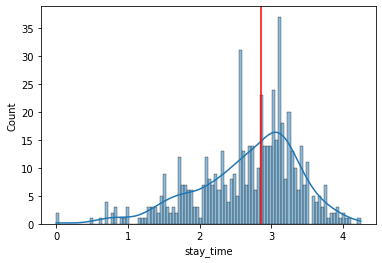

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(np.log10(move_data['stay_time'].dt.days), bins=100, kde=True)
# draw a vertical line at 2 years
plt.axvline(x=np.log10(365*2), color='red')
plt.show()

In [48]:
# demo_data = move_data[move_data['author_id'] == 'A5000148607']
# demo_data

,work_id,author_id,institution_id,move_time,next_work,next_ins,prev_ins,prev_work,leave_time,stay_time
289102,W2256398510,A5000148607,I165230279,2010-12-22,W2340804642,I165230279,NaN,NaN,2015-04-12,1572 days
293952,W2921287498,A5000148607,I1325598122,2015-04-12,W2608005917,I165230279,I165230279,W2617418182,2016-10-11,548 days
286884,W2608005917,A5000148607,I165230279,2016-10-11,W1550489553,I165230279,I1325598122,W2921287498,2017-10-12,366 days
344893,W2779473567,A5000148607,I1325598122,2017-10-12,W2883513507,I1325598122,I165230279,W2609087541,2020-03-06,876 days
362980,W3015359821,A5000148607,I165230279,2020-03-06,W3019024124,I165230279,I1325598122,W2883513507,NaT,NaT


In [49]:
# demo_data = demo_data[(demo_data['stay_time'] > pd.Timedelta(days=365*2)) | (pd.isna(demo_data['stay_time']))]
# demo_data

,work_id,author_id,institution_id,move_time,next_work,next_ins,prev_ins,prev_work,leave_time,stay_time
289102,W2256398510,A5000148607,I165230279,2010-12-22,W2340804642,I165230279,NaN,NaN,2015-04-12,1572 days
344893,W2779473567,A5000148607,I1325598122,2017-10-12,W2883513507,I1325598122,I165230279,W2609087541,2020-03-06,876 days
362980,W3015359821,A5000148607,I165230279,2020-03-06,W3019024124,I165230279,I1325598122,W2883513507,NaT,NaT


In [51]:
# demo_data.loc[:, 'prev_ins'] = demo_data['institution_id'].shift(1)
# demo_data
# # recalculate stay time


,work_id,author_id,institution_id,move_time,next_work,next_ins,prev_ins,prev_work,leave_time,stay_time
289102,W2256398510,A5000148607,I165230279,2010-12-22,W2340804642,I165230279,None,NaN,2015-04-12,1572 days
344893,W2779473567,A5000148607,I1325598122,2017-10-12,W2883513507,I1325598122,I165230279,W2609087541,2020-03-06,876 days
362980,W3015359821,A5000148607,I165230279,2020-03-06,W3019024124,I165230279,I1325598122,W2883513507,NaT,NaT


Apply the demo operations to all author groups in the whole dataset

In [55]:
# Group the move_data dataframe by author_id
move_data = move_data[(move_data['stay_time'] > pd.Timedelta(days=365*2)) | (pd.isna(move_data['stay_time']))]

move_data.loc[:, 'prev_ins'] = move_data.groupby('author_id')['institution_id'].shift(1)

move_data

,work_id,author_id,institution_id,move_time,next_work,next_ins,prev_ins,prev_work,leave_time,stay_time
289102,W2256398510,A5000148607,I165230279,2010-12-22,W2340804642,I165230279,NaN,NaN,2015-04-12,1572 days
344893,W2779473567,A5000148607,I1325598122,2017-10-12,W2883513507,I1325598122,I165230279,W2609087541,2020-03-06,876 days
362980,W3015359821,A5000148607,I165230279,2020-03-06,W3019024124,I165230279,I1325598122,W2883513507,NaT,NaT
131343,W2737511318,A5001157990,I51235708,2011-01-01,W1544793928,I4210088341,NaN,NaN,2014-07-28,1304 days
64210,W1544793928,A5001157990,I4210088341,2014-07-28,W2788550934,I4210088341,I51235708,W2737511318,2018-01-01,1253 days
...,...,...,...,...,...,...,...,...,...,...
47770,W2399005094,A5091588381,I32725510,2012-01-01,W1522548271,I32725510,NaN,W2199373919,2015-01-01,1096 days
111635,W2518273384,A5091588381,I17129648,2015-01-01,W3120457381,I32725510,I32725510,W1522548271,2019-10-01,1734 days
228616,W3120457381,A5091588381,I32725510,2019-10-01,NaN,NaN,I17129648,W2518273384,NaT,NaT
332756,W2619613433,A5091593818,I4210094250,2014-03-01,W2566500958,I4210094250,NaN,NaN,2016-12-01,1006 days


In [56]:
# recalculate stay time
move_data.loc[:, 'leave_time'] = move_data.groupby('author_id')['move_time'].shift(-1)
move_data.loc[:, 'stay_time'] = move_data['leave_time'] - move_data['move_time']
move_data

,work_id,author_id,institution_id,move_time,next_work,next_ins,prev_ins,prev_work,leave_time,stay_time
289102,W2256398510,A5000148607,I165230279,2010-12-22,W2340804642,I165230279,NaN,NaN,2017-10-12,2486 days
344893,W2779473567,A5000148607,I1325598122,2017-10-12,W2883513507,I1325598122,I165230279,W2609087541,2020-03-06,876 days
362980,W3015359821,A5000148607,I165230279,2020-03-06,W3019024124,I165230279,I1325598122,W2883513507,NaT,NaT
131343,W2737511318,A5001157990,I51235708,2011-01-01,W1544793928,I4210088341,NaN,NaN,2014-07-28,1304 days
64210,W1544793928,A5001157990,I4210088341,2014-07-28,W2788550934,I4210088341,I51235708,W2737511318,2018-01-01,1253 days
...,...,...,...,...,...,...,...,...,...,...
47770,W2399005094,A5091588381,I32725510,2012-01-01,W1522548271,I32725510,NaN,W2199373919,2015-01-01,1096 days
111635,W2518273384,A5091588381,I17129648,2015-01-01,W3120457381,I32725510,I32725510,W1522548271,2019-10-01,1734 days
228616,W3120457381,A5091588381,I32725510,2019-10-01,NaN,NaN,I17129648,W2518273384,NaT,NaT
332756,W2619613433,A5091593818,I4210094250,2014-03-01,W2566500958,I4210094250,NaN,NaN,2016-12-01,1006 days


We cannot obtain the stay time in the final institution so there might be some false positives.

In [57]:
move_data.to_csv('data/move_data.csv')